In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from numpy import load
from keras import layers
from tensorflow import keras
from keras.layers import Input, Layer, GRU, Dropout, Dense
from keras.models import Sequential, Model
import numpy as np

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/train_data/ILDC_multi.csv')
x_train0 = load("/content/drive/MyDrive/Thesis/Models_whole_data/transformers_sentence_level/LSGBERT_multi_2560_512/LSGBERT_npy_files_cls_multi/LSGBERT_cls_train.npy", allow_pickle = True)
x_dev0 = load("/content/drive/MyDrive/Thesis/Models_whole_data/transformers_sentence_level/LSGBERT_multi_2560_512/LSGBERT_npy_files_cls_multi/LSGBERT_cls_dev.npy", allow_pickle= True)
x_test0 = load("/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/only_annotation/compute_embs_anno/LSGBERT_npy_files_cls_multi_anno/LSGBERT_cls_test_anno.npy", allow_pickle= True)

In [4]:
len(x_test0)

56

In [5]:
len(x_test0[0][1])

768

In [6]:
# loading the corresponding label for each case in dataset
dev = dataset.loc[dataset['split'] == 'dev']
train = dataset.loc[dataset['split'] == 'train']

y_train0 = []
for i in range(train.shape[0]):
    y_train0.append(train.loc[i,'label'])

y_dev0 = []
for i in range(dev.shape[0]):
    y_dev0.append(dev.loc[i+32305,'label'])


In [7]:
test = pd.read_csv('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/ILDC_expert/anno_dataset.csv')

In [8]:
test

,text,name,label
0,"The assessee, Her Highness Maharani Kesarkunve...",1960_12.txt,1
1,CIVIL APPELLATE JURISDICTION Civil Appeal No. ...,1953_14.txt,1
2,CIVIL APPELLATE JURISDICTION Civil - Appeal No...,1952_60.txt,1
3,CIVIL APPELLATE JURISDICTION. Civil Appeal No....,1951_64.txt,1
4,Appeal by special leave from the award dated D...,1962_384.txt,1
5,Special leave granted.\n Respondent 1 was sus...,1999_1001.txt,1
6,Appeal by special leave from the judgment and ...,1961_344.txt,0
7,These appeals are directed against three judgm...,1960_44.txt,1
8,Appeal by special leave from the Resolution da...,1962_113.txt,0
9,"The award made by the Industrial Tribunal, Bom...",1959_66.txt,1


In [9]:
y_test0 = list(test['label'])

In [10]:
# model.add(AttentionLayer())
text_input = Input(shape=(None,768,), dtype='float32', name='text') #1 sent_input
print("text input",text_input)
l_mask = layers.Masking(mask_value=-99.)(text_input) #2 sent_encoder
print("l_mask",l_mask)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask) #3 sent_gru
encoded_text1 = layers.Bidirectional(GRU(100,return_sequences=False))(encoded_text) #4
# out_dense = layers.Dense(200, activation='relu')(encoded_text1) #5 sent_dense
sent_drop = Dropout(0.5,name='sent_dropout')(encoded_text1)
# And we add a softmax classifier on top
out1 = layers.Dense(30, activation='relu')(sent_drop) #7 preds
out = layers.Dense(1, activation='sigmoid')(out1)
model = Model(text_input,out)


model.summary()

text input KerasTensor(type_spec=TensorSpec(shape=(None, None, 768), dtype=tf.float32, name='text'), name='text', description="created by layer 'text'")
l_mask KerasTensor(type_spec=TensorSpec(shape=(None, None, 768), dtype=tf.float32, name=None), name='masking/mul:0', description="created by layer 'masking'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 200)         522000    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               181200    
 onal)       

In [11]:
model.load_weights('/content/drive/MyDrive/Thesis/Models_whole_data/transformers_sentence_level/LSGBERT_multi_2560_512/BIGRU_LSGBERT_cls.h5')

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [13]:
new_test_x = [] #  Queste due liste vuote vengono create per ospitare i nuovi dati di test occlusi.
new_test_y = []
for i in range(len(x_test0)): #  Questo è un loop che scorre attraverso tutti i campioni nei dati di test originali
  full_emb = x_test0[i] #  full_emb è l'embedding completo del campione corrente, che è estratto dai dati di test originali.
  label = y_test0[i] # label è l'etichetta corrispondente al campione corrente, estratta dai dati delle etichette di test originali
  new_test_x.append(full_emb) #  L'embedding completo del campione corrente viene aggiunto alla lista new_test_x, che inizialmente conterrà le versioni non occluse dei dati di input.
  new_test_y.append(label) # L'etichetta corrispondente viene aggiunta alla lista new_test_y
  for j in range(len(full_emb)): #  Questo è un loop interno che scorre attraverso ciascuna dimensione dell'embedding del campione corrente. j è l'indice della dimensione corrente.
    emb_occluded = [] # Viene creata una lista vuota emb_occluded che conterrà l'embedding occluso.
    for k in range(len(full_emb)): # Questo è un altro loop interno che scorre attraverso tutte le dimensioni dell'embedding originale (full_emb).
      if(k==j): # Se l'indice k è uguale all'indice j (cioè stiamo analizzando la stessa dimensione dell'embedding)
        emb_occluded.append(np.zeros(768)) #  viene aggiunto un vettore di zeri (np.zeros(768)) alla lista emb_occluded. In pratica, qui stiamo oscurando una dimensione dell'embedding.
      else:
        emb_occluded.append(full_emb[k]) # Se l'indice k non è uguale a j, viene aggiunta la corrispondente dimensione dell'embedding originale alla lista emb_occluded
  # Alla fine del loop interno, la lista emb_occluded conterrà l'embedding con una delle sue dimensioni oscurata.
    new_test_x.append(emb_occluded) #  L'embedding occluso viene aggiunto alla lista new_test_x.
    new_test_y.append(label) # L'etichetta corrispondente viene nuovamente aggiunta alla lista new_test_y.

In [14]:
print(y_test0[0])

1


In [15]:
print(len(new_test_x[0]),len(new_test_x[1]),len(new_test_x[2]),len(new_test_x[3]),len(new_test_x[10]))

7 7 7 7 14


In [18]:
new_test_x[2]

[array([ 7.70943224e-01, -6.16254747e-01, -1.56267554e-01,  1.11616001e-01,
         2.22131327e-01,  1.31736070e-01, -9.63036954e-01, -1.21521227e-01,
         7.42130280e-01, -9.43667907e-03, -5.68425477e-01,  3.96866500e-02,
         1.03924900e-01, -2.58087993e-01, -4.35604483e-01,  5.57873368e-01,
         2.52598166e-01, -1.36587054e-01,  4.61245067e-02,  1.22835374e+00,
        -6.76082224e-02, -9.72182155e-02,  8.94879103e-01,  1.96570858e-01,
         4.76330742e-02,  5.94901919e-01, -1.67083159e-01,  3.63375485e-01,
        -8.77021134e-01,  2.81230181e-01, -4.49688807e-02, -7.85189494e-02,
         1.33049762e+00, -2.68185318e-01, -1.78755060e-01,  7.17537940e-01,
         5.28073668e-01,  1.68580621e-01, -7.06256628e-01, -8.33032727e-01,
        -1.08926602e-01, -3.46524805e-01, -4.85299647e-01, -2.34905571e-01,
         2.02921465e-01, -4.54030186e-01, -4.27906036e+00,  1.18560755e+00,
        -7.54078269e-01, -8.10595825e-02,  6.70557261e-01,  4.16117072e-01,
         4.6

In [19]:
num_features= 768
def new_test_generator():
    x_list= new_test_x
    y_list =  new_test_y
    # Generate batches
    while True:
      for b in range(batches_per_epoch_test):
        longest_index = (b + 1) * batch_size_test - 1
        timesteps = len(max(new_test_x[:(b + 1) * batch_size_test][-batch_size_test:], key=len))
        # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
        x_train = np.full((batch_size_test, timesteps, num_features), -99.)
        y_train = np.zeros((batch_size_test,  1))
        for i in range(batch_size_test):
            li = b * batch_size_test + i
            # print("runs")
            # print(len(x_list[li]))
            # print("li", li)
            # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
            x_train[i, 0:len(x_list[li]), :] = x_list[li]
            y_train[i] = y_list[li]
        yield x_train, y_train

In [22]:
num_sequences_test = len(new_test_x)
print(num_sequences_test)
batch_size_test = 32
if(num_sequences_test%batch_size_test == 0):
  batches_per_epoch_test = int(num_sequences_test/batch_size_test)
else:
  batches_per_epoch_test = int(num_sequences_test/batch_size_test) + 1
#assert batch_size_val * batches_per_epoch_val == num_sequences_val
model.evaluate_generator(new_test_generator(), steps= batches_per_epoch_test)

544


<ipython-input-22-9ba2bae66fcf>:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(new_test_generator(), steps= batches_per_epoch_test)


[0.587615966796875, 0.7113970518112183]

In [23]:
preds = model.predict_generator(new_test_generator(), steps= batches_per_epoch_test)
print(len(preds))

<ipython-input-23-7d4a2c1f7140>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(new_test_generator(), steps= batches_per_epoch_test)


544


In [24]:
scores = []  #Inizializza una lista vuota chiamata scores che conterrà gli score di occlusione per ciascun campione nel set di test.

startpt = 0 # Inizializza un indice startpt che tiene traccia della posizione corrente nell'array delle previsioni (preds).
for i in range(len(x_test0)): #  Inizia un loop che scorre attraverso ciascun campione nel set di test. x_test0 contiene gli embedding dei campioni, quindi len(x_test0) rappresenta il numero totale di campioni nel set di test.
  n_emb_for_this_doc = x_test0[i].shape[0] # Ottiene il numero di embedding (dimensioni dell'embedding) per il campione corrente.
  tot_embs = n_emb_for_this_doc + 1 # Calcola il numero totale di embedding inclusi il campione originale e i campioni occlusi.
  act_pred = preds[startpt] > 0.5 # Determina se la previsione fatta dal modello per il campione originale è maggiore di 0.5, indicando che il modello ha classificato il campione come positivo.

  chunk_scores = [] #  Inizializza una lista vuota chunk_scores che conterrà gli score di occlusione per ciascun "chunk" (campione originale e campioni occlusi) del campione corrente.
  for j in range(tot_embs-1): # Inizia un loop che scorre attraverso ciascun "chunk" (campione occluso) del campione corrente.
    if(act_pred): # se è vero (il modello ha previsto positivo per il campione originale)
      chunk_scores.append(-1*(preds[startpt+j+1]-preds[startpt])) # Viene calcolato uno score di occlusione come la differenza negativa tra la previsione del modello per il chunk occluso e la previsione del modello per il campione originale. Questo è il valore -1*(preds[startpt+j+1]-preds[startpt]).
    else:
      chunk_scores.append(preds[startpt+j+1]-preds[startpt]) # Viene calcolato uno score di occlusione come la differenza positiva tra la previsione del modello per il chunk occluso e la previsione del modello per il campione originale (preds[startpt+j+1]-preds[startpt]).

  scores.append(chunk_scores) # Aggiunge la lista chunk_scores (contenente gli score di occlusione per il campione corrente) alla lista globale scores.
  startpt += tot_embs # Aggiorna l'indice startpt in modo che punti alla posizione successiva nelle previsioni (preds) per il prossimo campione.

# In breve, questa parte di codice calcola gli score di occlusione per ogni campione nel set di test, dove uno score di occlusione rappresenta quanto una dimensione dell'embedding influisce sulla previsione del modello.
# Gli score vengono calcolati confrontando le previsioni del modello per i chunk occlusi con le previsioni per il campione originale.

In [25]:
print(len(scores))

56


In [26]:

l_scores = [] #  Inizializza una lista vuota chiamata l_scores che conterrà gli score di occlusione semplificati.
for s in scores: # Inizia un loop che scorre attraverso ogni elemento nella lista scores. Ogni elemento s in questo caso è una lista di score di occlusione per un determinato campione.
  c_s =[] # Inizializza una nuova lista vuota chiamata c_s che conterrà gli score di occlusione semplificati per il campione corrente.
  for c in s: # Inizia un loop interno che scorre attraverso ogni elemento c (che rappresenta uno score di occlusione) nella lista s (score di occlusione per un campione specifico).
    c_s.append(c[0]) # : Aggiunge il primo elemento di ogni score di occlusione c alla lista c_s. Questo passo semplifica gli score di occlusione a un valore numerico singolo (il primo elemento dell'array c), che rappresenta l'effetto di occlusione su una dimensione dell'embedding.
    # Alla fine del loop interno, la lista c_s conterrà gli score di occlusione semplificati per il campione corrente.
  l_scores.append(c_s) #  Aggiunge la lista c_s (contenente gli score di occlusione semplificati per un campione) alla lista l_scores.

# In sintesi, questo pezzo di codice raccoglie gli score di occlusione semplificati da una struttura più complessa in una nuova lista l_scores, dove ogni elemento in l_scores è una lista di score di occlusione semplificati per un campione specifico.


In [27]:
print(l_scores[0])

[0.008799218, 0.011762351, 0.015625514, 0.0071260333, -0.016006775, 0.39031607, 0.13743185]


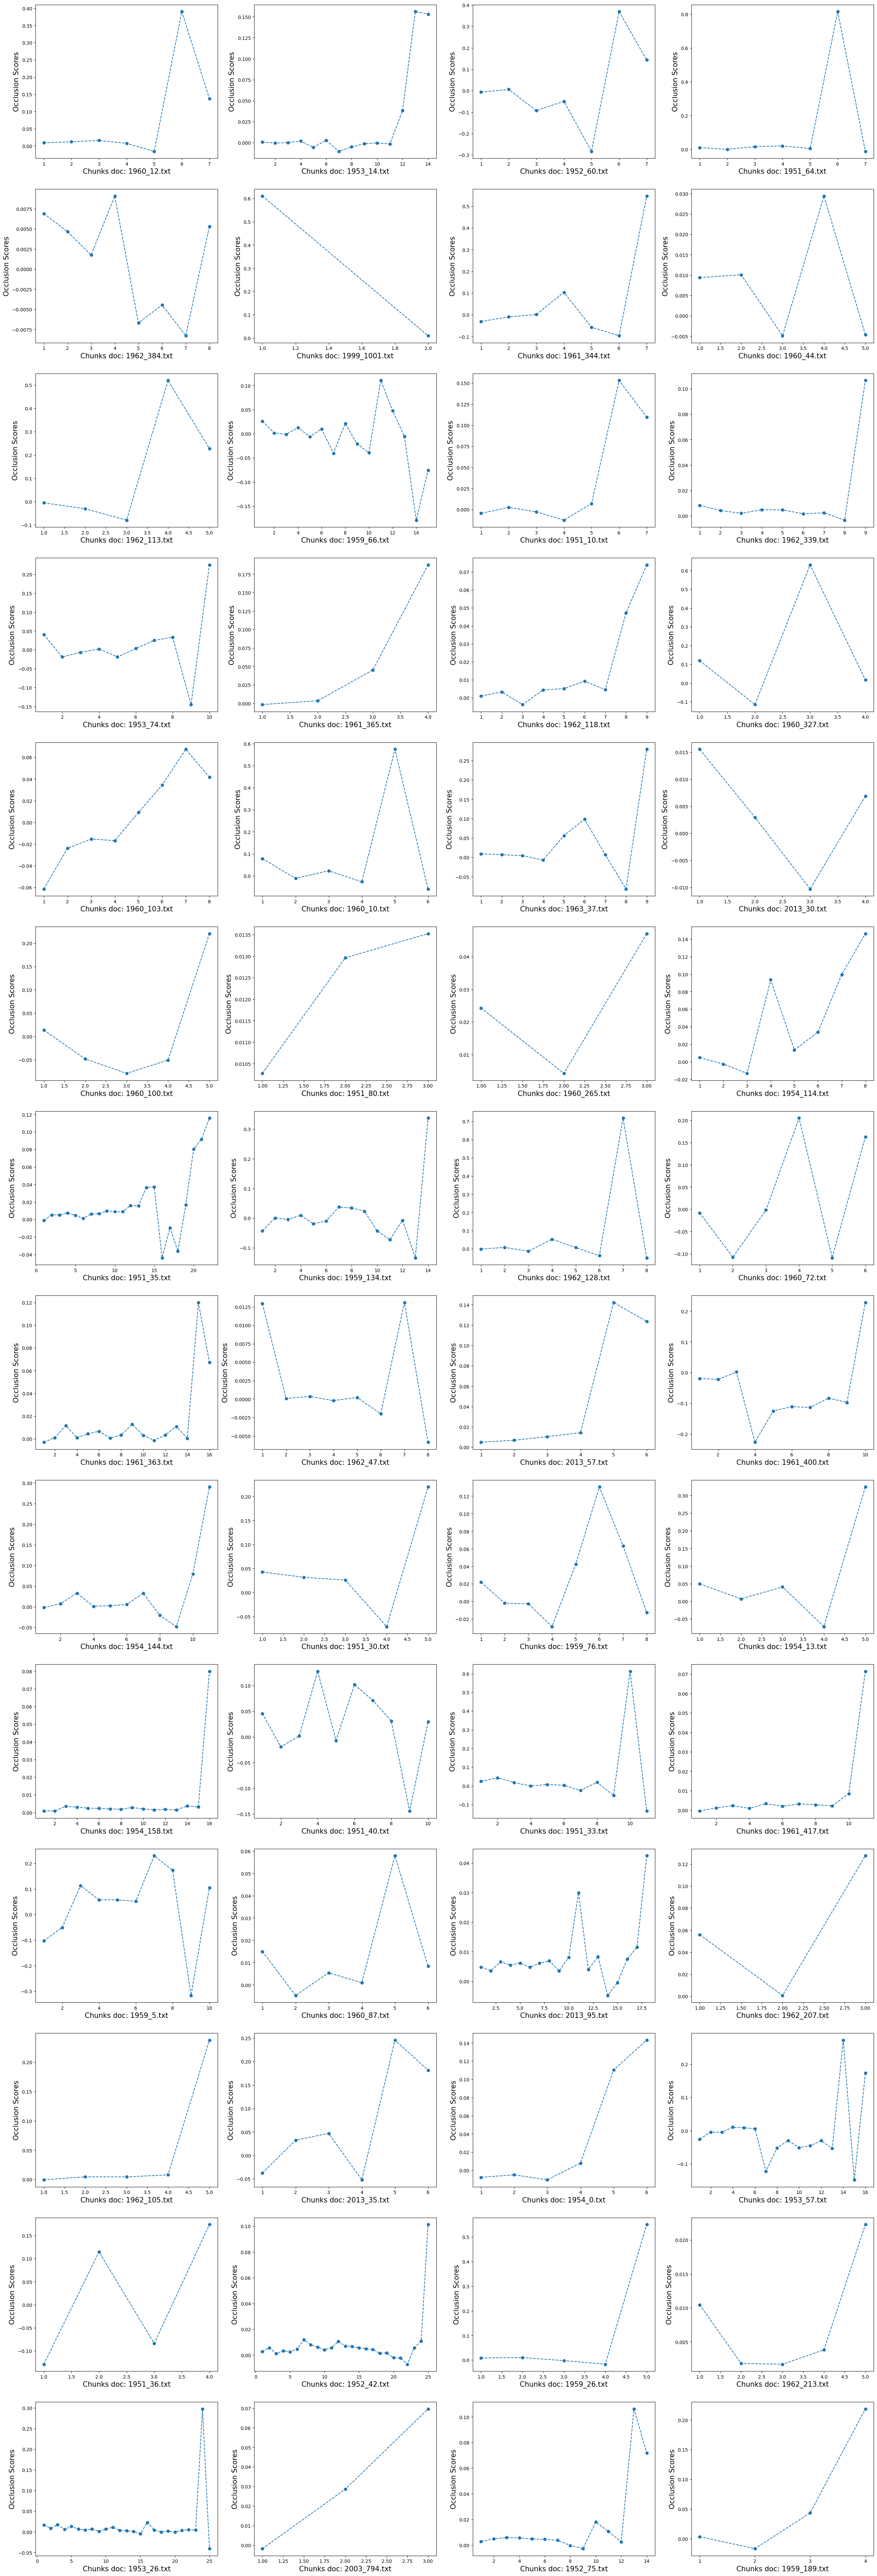

In [31]:
# Questo pezzo di codice genera una visualizzazione con un layout a griglia di subplot, dove ogni subplot rappresenta gli score di occlusione semplificati per un campione specifico.
# Ogni grafico mostra come gli score di occlusione variano in base alle diverse dimensioni dell'embedding.

import matplotlib.pyplot as plt

fig, axs = plt.subplots(14, 4, figsize=(32, 98))
l=0
r=0
for i, sc in enumerate(l_scores):
  plt.xticks(list(range(1,len(sc)+1,1)))

  y = list(range(1,len(sc)+1,1))
  axs[l,r].plot(y, sc, marker='o', linestyle='dashed')
  axs[l,r].set_xlabel('Chunks doc: '+ test.iloc[i]['name'],fontsize = 15.0)
  axs[l,r].set_ylabel('Occlusion Scores',fontsize = 15.0)


  r+=1
  if(r==4):
    l+=1
    r=0


In [32]:
#plt.savefig('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/only_annotation/occlusion_anno/occ_scores_anno.png', bbox_inches='tight')
#plt.savefig('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/only_annotation/occlusion_anno/occ_scores_anno.eps', format='eps', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [33]:
scores = []
act_predictions = []

startpt = 0
for i in range(len(x_test0)):
  n_emb_for_this_doc = x_test0[i].shape[0]
  tot_embs = n_emb_for_this_doc + 1
  act_pred = preds[startpt] > 0.5
  act_predictions.append(act_pred)
  startpt += tot_embs

In [34]:
for i in range(len(act_predictions)):
  print("{:} true = {:}, pred = {:}, iscorrect = {:}".format(i+1,y_test0[i],act_predictions[i], y_test0[i] == act_predictions[i]))

1 true = 1, pred = [False], iscorrect = [False]
2 true = 1, pred = [False], iscorrect = [False]
3 true = 1, pred = [False], iscorrect = [False]
4 true = 1, pred = [ True], iscorrect = [ True]
5 true = 1, pred = [ True], iscorrect = [ True]
6 true = 1, pred = [ True], iscorrect = [ True]
7 true = 0, pred = [False], iscorrect = [ True]
8 true = 1, pred = [ True], iscorrect = [ True]
9 true = 0, pred = [False], iscorrect = [ True]
10 true = 1, pred = [ True], iscorrect = [ True]
11 true = 1, pred = [False], iscorrect = [False]
12 true = 1, pred = [ True], iscorrect = [ True]
13 true = 1, pred = [ True], iscorrect = [ True]
14 true = 0, pred = [False], iscorrect = [ True]
15 true = 0, pred = [False], iscorrect = [ True]
16 true = 1, pred = [ True], iscorrect = [ True]
17 true = 1, pred = [False], iscorrect = [False]
18 true = 1, pred = [ True], iscorrect = [ True]
19 true = 1, pred = [ True], iscorrect = [ True]
20 true = 1, pred = [ True], iscorrect = [ True]
21 true = 0, pred = [ True], 

In [39]:
len(l_scores)

56

In [40]:
#np.save("/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/only_annotation/occlusion_anno/occwts_anno.npy", l_scores)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
